# Results

In [1]:
import numpy as np
from haystack.modeling.evaluation.squad_evaluation import compute_f1
import pandas as pd
from scipy import stats
# advanced spearmanr when f1 scores are all 0
from scipy.stats.mstats import spearmanr, kendalltau

from collections import defaultdict

from transformers import AutoConfig

import seaborn

from matplotlib import pyplot

import warnings
warnings.simplefilter("ignore")

In [2]:
from cycler import cycler
# pyplot.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
pyplot.rcParams['axes.prop_cycle'] = cycler(
    color=[pyplot.cm.Paired(i) for i in np.linspace(0, 1, 6)])

In [3]:
DATA_PATH = 'data/table'

In [4]:
pd.options.display.float_format = '{:,.3f}'.format

In [5]:
german_quad = pd.read_csv(f'{DATA_PATH}/german_quad_table_results.csv', index_col=0)
nq_open = pd.read_csv(f'{DATA_PATH}/nq_open_table_results.csv', index_col=0)
squad = pd.read_csv(f'{DATA_PATH}/squad_table_results.csv', index_col=0)

In [6]:
german_quad = pd.read_csv(f'{DATA_PATH}/german_quad_table_results.csv', index_col=0)
nq_open = pd.read_csv('data/errors/nq_open_corrected_and_augmented.csv', index_col=0)
squad = pd.read_csv(f'{DATA_PATH}/squad_table_results.csv', index_col=0)

In [7]:
METRICS_OF_INTEREST = ['bleu', 'rouge_L', 'meteor', 'f1', 'bi_encoder', 'bertvanilla', 'berttrained', 'sas']

In [6]:
# ### Bleu 

# bleu = load_metric('bleu')

# for dataset in [squad, german_quad, nq_open]:
#     temp_1 = dataset.apply(lambda x: str(x.answer1).split(), axis=1) 
#     temp_2 = dataset.apply(lambda x: str(x.answer2).split(), axis=1)

#     bleu_scores = []
#     for i in range(len(dataset.answer1)):
#         bleu_scores.append(bleu.compute(
#             predictions=[temp_1[i]], references=[[temp_2[i]]])['bleu'])
#     dataset['bleu'] = bleu_scores

# ### Rouge

# rouge = load_metric('rouge', seed=42)

# for dataset in [squad, german_quad, nq_open]:
#     dataset['rouge_L'] = dataset.apply(lambda x: rouge.compute(
#         predictions=[str(x.answer1)], 
#         references=[str(x.answer2)], 
#         rouge_types=["rougeL"], 
#         use_agregator=False)['rougeL'][0].fmeasure,
#                                       axis = 1)

# ### Meteor

# meteor = load_metric('meteor')


# for dataset in [squad, german_quad, nq_open]:
#     dataset['meteor'] = dataset.apply(lambda x: meteor.compute(
#         predictions=[str(x.answer1)], references=[str(x.answer2)])['meteor'],
#                                       axis=1)

# german_quad.to_csv(f'{DATA_PATH}/german_quad_table_results.csv')
# nq_open.to_csv(f'{DATA_PATH}/nq_open_table_results.csv')
# squad.to_csv(f'{DATA_PATH}/squad_table_results.csv')

## Table

In [55]:
def get_datasets_info():
    datasets = [squad, german_quad, nq_open]
    for dataset in datasets:
        dataset.drop_duplicates(inplace=True)
        dataset['answer_1_len'] = dataset.apply(lambda x: len(str(x.answer1)), axis=1)
        dataset['answer_2_len'] = dataset.apply(lambda x: len(str(x.answer2)), axis=1)

    dataset_f1_scores = {
        'SQuAD': [
            squad[squad.f1 == 0].shape[0],
            squad[squad.f1 != 0].shape[0]
        ],
        'GermanQuAD': [
            german_quad[german_quad.f1 == 0].shape[0],
            german_quad[german_quad.f1 != 0].shape[0]
        ],
        'NQ-open': [
            nq_open[nq_open.f1 == 0].shape[0],
            nq_open[nq_open.f1 != 0].shape[0]
        ]
    }

    dataset_table = pd.DataFrame(dataset_f1_scores).T

    dataset_table['Size'] = list(map(len, [squad, german_quad, nq_open]))

    dataset_table['Average answer size'] = [
        round(np.mean([np.mean(dataset.answer_1_len),
                 np.mean(dataset.answer_2_len)])) for dataset in datasets
    ]

    return dataset_table

In [34]:
def create_results_table(datasets, return_paper_labels=True):
    all_results = defaultdict(list)

    temp = pd.DataFrame(columns=METRICS_OF_INTEREST)
    temp_fn0 = pd.DataFrame(columns=METRICS_OF_INTEREST)


    for index, dataset in enumerate(datasets):
        for metric in temp.columns: 
            temp.loc['rho_prime', metric] = np.nan_to_num(round(
                stats.pearsonr(dataset[dataset.f1 == 0].dropna()[metric],
                         dataset[dataset.f1 == 0].dropna()['label'])[0], 3))
            temp.loc['rho', metric] = np.nan_to_num(round(
                spearmanr(dataset[dataset.f1 == 0].dropna()[metric],
                         dataset[dataset.f1 == 0].dropna()['label'])[0], 3))
            temp.loc['tau', metric] = np.nan_to_num(round(
                stats.kendalltau(dataset[dataset.f1 == 0].dropna()[metric],
                         dataset[dataset.f1 == 0].dropna()['label'])[0], 3))
            temp_fn0.loc['rho_prime', metric] = np.nan_to_num(round(
                stats.pearsonr(dataset[dataset.f1 != 0].dropna()[metric],
                         dataset[dataset.f1 != 0].dropna()['label'])[0], 3))
            temp_fn0.loc['rho', metric] = np.nan_to_num(round(
                stats.spearmanr(dataset[dataset.f1 != 0].dropna()[metric],
                         dataset[dataset.f1 != 0].dropna()['label'])[0], 3))
            temp_fn0.loc['tau', metric] = np.nan_to_num(round(
                stats.kendalltau(dataset[dataset.f1 != 0].dropna()[metric],
                         dataset[dataset.f1 != 0].dropna()['label'])[0], 3))
            dataset_results = pd.concat([temp, temp_fn0], axis=0)
        all_results[index].append(dataset_results)
    new_df = pd.DataFrame()
    for i in range(len(datasets)):
        new_df = pd.concat([new_df , all_results[i][0].T], axis=1)
    if return_paper_labels: 

        new_df.index = [
            'BLEU', 'ROUGE-L', 'METEOR', 'F1-score', 'Bi-Encoder', 'BERTScore vanilla',
            'BERTScore trained', 'SAS'
        ]
    return new_df

In [8]:
def get_models_info():
    all_models = [
        'deepset/gbert-large-sts', 
        'cross-encoder/stsb-roberta-large',
        'T-Systems-onsite/cross-en-de-roberta-sentence-transformer',
        'bert-base-uncased',
        'deepset/gelectra-base'
    ]

    configs = [AutoConfig.from_pretrained(i) for i in all_models]

    config_df = pd.concat([pd.DataFrame(
        AutoConfig.from_pretrained(model_type).get_config_dict(model_type)).iloc[
                0:1, :].T for model_type in all_models], axis=1)

    config_df.columns = all_models
    return config_df

In [21]:
def add_gridlines_remove_spines():
    ''' Prettify matplotlib plots by adding grid lines and removing right and top spines. '''
    axes = pyplot.gcf().get_axes()
    for axis in axes:
        axis.set_axisbelow(True)
        axis.grid(b=True, which='major', color='#666666', linestyle='-', alpha=0.6)
        axis.minorticks_on()
        axis.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    seaborn.despine()

In [56]:
get_datasets_info()

,0,1,Size,Average answer size
SQuAD,565,374,939,23
GermanQuAD,124,299,423,68
NQ-open,3099,536,3635,13


In [46]:
old_results = create_results_table([squad, nq_open])

In [40]:
new_results = create_results_table([squad, nq_open])

In [42]:
create_results_table([german_quad]).drop('METEOR')

In [51]:
((new_results - old_results) * 100).iloc[:, 6:]

,rho_prime,rho,tau,rho_prime,rho,tau
BLEU,0.0,0.0,0.0,-0.5,-0.5,-0.5
ROUGE-L,-0.5,-0.7,-0.6,0.0,0.0,0.2
METEOR,3.3,1.1,1.0,-0.9,-1.0,-0.7
F1-score,0.0,0.0,0.0,-1.3,-1.2,-0.8
Bi-Encoder,1.0,1.2,1.0,1.2,1.1,1.0
BERTScore vanilla,-0.6,-0.6,-0.6,-2.0,-2.2,-1.7
BERTScore trained,1.1,1.2,1.0,1.0,0.9,0.8
SAS,1.3,0.9,0.8,0.9,1.8,1.6


In [44]:
new_results

,rho_prime,rho,tau,rho_prime,rho,tau,rho_prime,rho,tau,rho_prime,rho,tau
BLEU,0.000,0.000,0.000,0.182,0.168,0.159,0.000,0.000,0.000,0.082,0.084,0.079
ROUGE-L,0.100,0.043,0.041,0.556,0.537,0.455,0.132,0.117,0.114,0.402,0.408,0.336
METEOR,0.398,0.207,0.200,0.450,0.464,0.378,0.213,0.148,0.143,0.186,0.163,0.127
F1-score,0.000,0.000,0.000,0.594,0.579,0.497,0.000,0.000,0.000,0.361,0.367,0.306
Bi-Encoder,0.487,0.372,0.303,0.684,0.684,0.566,0.242,0.196,0.157,0.392,0.387,0.305
BERTScore vanilla,0.249,0.132,0.108,0.612,0.601,0.492,0.117,0.145,0.115,0.125,0.103,0.081
BERTScore trained,0.516,0.391,0.318,0.698,0.688,0.571,0.265,0.209,0.168,0.391,0.390,0.308
SAS,0.561,0.359,0.291,0.743,0.735,0.613,0.327,0.171,0.138,0.547,0.554,0.439


In [54]:
old_results

,rho_prime,rho,tau,rho_prime,rho,tau,rho_prime,rho,tau,rho_prime,rho,tau
BLEU,0.000,0.000,0.000,0.182,0.168,0.159,0.000,0.000,0.000,0.087,0.089,0.084
ROUGE-L,0.100,0.043,0.041,0.556,0.537,0.455,0.137,0.124,0.120,0.402,0.408,0.334
METEOR,0.398,0.207,0.200,0.450,0.464,0.378,0.180,0.137,0.133,0.195,0.173,0.134
F1-score,0.000,0.000,0.000,0.594,0.579,0.497,0.000,0.000,0.000,0.374,0.379,0.314
Bi-Encoder,0.487,0.372,0.303,0.684,0.684,0.566,0.232,0.184,0.147,0.380,0.376,0.295
BERTScore vanilla,0.249,0.132,0.108,0.612,0.601,0.492,0.123,0.151,0.121,0.145,0.125,0.098
BERTScore trained,0.516,0.391,0.318,0.698,0.688,0.571,0.254,0.197,0.158,0.381,0.381,0.300
SAS,0.561,0.359,0.291,0.743,0.735,0.613,0.314,0.162,0.130,0.538,0.536,0.423


In [57]:
german_quad

,answer1,answer2,label,berttrained,f1,sas,bertvanilla,bi_encoder,bleu,rouge_L,meteor,answer_1_len,answer_2_len
0,rotiert,schwingt bei vertikaler Polarisation der elektrische Feldvektor zwischen obe...,0.000,0.230,0.000,0.223,0.384,0.174,0.000,0.000,0.000,7,144
1,in Blautönen gehaltenen Außenwände,Blaues,1.000,0.588,0.000,0.507,0.588,0.580,0.000,0.000,0.000,34,6
2,'Anorthotiko Komma Ergazomenou Laou'',Fortschrittspartei des werktätigen Volkes,2.000,0.058,0.000,0.042,0.349,-0.040,0.000,0.000,0.000,37,41
3,aus dem englischen,"von ‚Geißel‘, ‚Seuche‘ und lat. ‚töten‘",0.000,0.327,0.000,0.128,0.457,0.207,0.000,0.000,0.000,18,41
4,Ramadan-Monat,sind üblicherweise an den Rändern der Koranexemplare markiert,0.000,0.318,0.000,0.124,0.463,0.292,0.000,0.000,0.000,13,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420,die Landesverteidigung oder die Außenpolitik,nur bestimmte Angelegenheiten – etwa die Landesverteidigung oder die Außenpo...,1.000,0.770,0.625,0.632,0.803,0.705,0.301,0.750,0.479,44,83
421,"kein Zentralstaat, sondern eine Konföderation von Provinzen",Die Republik war kein Zentralstaat,1.000,0.580,0.333,0.627,0.666,0.563,0.000,0.308,0.354,59,34
422,Holland,Wichtigste Provinz der Union war die Provinz Holland,1.000,0.544,0.222,0.524,0.642,0.572,0.000,0.222,0.068,7,52
423,"Chopin wurde in Żelazowa Wola geboren, einem Dorf in der Gemeinde Brochów, D...",in Żelazowa Wola,1.000,0.483,0.286,0.444,0.632,0.468,0.000,0.273,0.522,129,16


In [9]:
def vis_hist_label(df_):
    print()
    print(df_["label"].unique(), df_["label"].count())
#     sns.set(style="darkgrid")
    fig, axs = pyplot.subplots(2, 2, figsize=(7, 7))
    df_["f1_0"] = df_["f1"]==0
    seaborn.histplot(data=df_, x="bi_encoder", kde=True, ax=axs[0, 0], binrange=[0,1], hue="f1_0")
    seaborn.histplot(data=df_, x="bertvanilla", kde=True, ax=axs[0, 1], binrange=[0,1], hue="f1_0")
    seaborn.histplot(data=df_, x="berttrained", kde=True,  ax=axs[1, 0], binrange=[0,1], hue="f1_0")
    seaborn.histplot(data=df_, x="sas", kde=True, ax=axs[1, 1], binrange=[0,1], hue="f1_0")
    fig.suptitle('GermanQuAD (F1=0 vs. F1!=0)')
#     fig.savefig('gquad_f1_0.png', dpi=100)
    add_gridlines_remove_spines()
#     plt.show()


[ 0.  1.  2. nan] 421


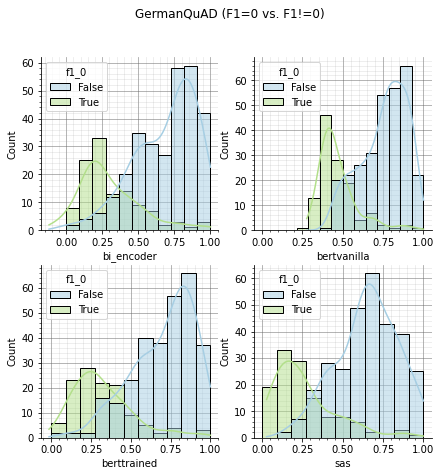

In [70]:
vis_hist_label(german_quad)

NameError: name 'add_gridlines_remove_spines' is not defined

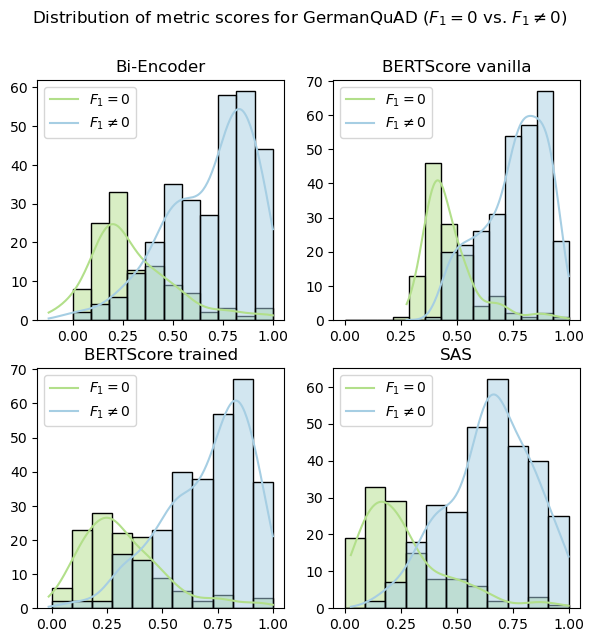

In [10]:
df_ = german_quad.copy()
fig, axs = pyplot.subplots(2, 2, figsize=(7, 7), dpi=100)
df_["f1_0"] = df_["f1"]==0
seaborn.histplot(data=df_, x="bi_encoder", kde=True, ax=axs[0, 0], binrange=[0,1], hue="f1_0", legend=False)


seaborn.histplot(data=df_, x="bertvanilla", kde=True, ax=axs[0, 1], binrange=[0,1], hue="f1_0", legend=False)


seaborn.histplot(data=df_, x="berttrained", kde=True,  ax=axs[1, 0], binrange=[0,1], hue="f1_0", legend=False)


seaborn.histplot(data=df_, x="sas", kde=True, ax=axs[1, 1], binrange=[0,1], hue="f1_0", legend=False)
pyplot.setp(axs.flat, xlabel='', ylabel='')


axs[0, 0].title.set_text("Bi-Encoder")
axs[0, 1].title.set_text("BERTScore vanilla")
axs[1, 0].title.set_text("BERTScore trained")
axs[1, 1].title.set_text("SAS")
for i in (0, 1):
    for j in (0, 1):
        axs[i, j].legend([r'$F_1 = 0$', r'$F_1 \neq 0$'])

fig.suptitle(r'Distribution of metric scores for GermanQuAD ($F_1=0$ vs. $F_1 \neq 0$)')
#     fig.savefig('gquad_f1_0.png', dpi=100)
add_gridlines_remove_spines()

In [12]:
german_quad.berttrained.min()

-0.0143339708447456

In [96]:
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]


In [98]:
fig.axes

[<AxesSubplot:title={'center':'Bi-Encoder'}>,
 <AxesSubplot:title={'center':'BERTScore vanilla'}>,
 <AxesSubplot:title={'center':'BERTScore trained'}>,
 <AxesSubplot:title={'center':'SAS'}>]

In [73]:
ax[0, 0].title.set_text("Bi-Encoder")
ax[0, 1].title.set_text("BERTScore vanilla")
ax[1, 0].title.set_text("BERTScore trained")
ax[1, 1].title.set_text("SAS")

Help on function setp in module matplotlib.pyplot:

setp(obj, *args, **kwargs)
    Set one or more properties on an `.Artist`, or list allowed values.
    
    Parameters
    ----------
    obj : `.Artist` or list of `.Artist`
        The artist(s) whose properties are being set or queried.  When setting
        properties, all artists are affected; when querying the allowed values,
        only the first instance in the sequence is queried.
    
        For example, two lines can be made thicker and red with a single call:
    
        >>> x = arange(0, 1, 0.01)
        >>> lines = plot(x, sin(2*pi*x), x, sin(4*pi*x))
        >>> setp(lines, linewidth=2, color='r')
    
    file : file-like, default: `sys.stdout`
        Where `setp` writes its output when asked to list allowed values.
    
        >>> with open('output.log') as file:
        ...     setp(line, file=file)
    
        The default, ``None``, means `sys.stdout`.
    
    *args, **kwargs
        The properties to set.  T

In [ ]:
pyplot.setp(axes.flat, xlabel='Bi-Encoder', ylabel='')



[ 0.  1.  2. nan] 421


ValueError: Could not interpret value `f1_0` for parameter `hue`

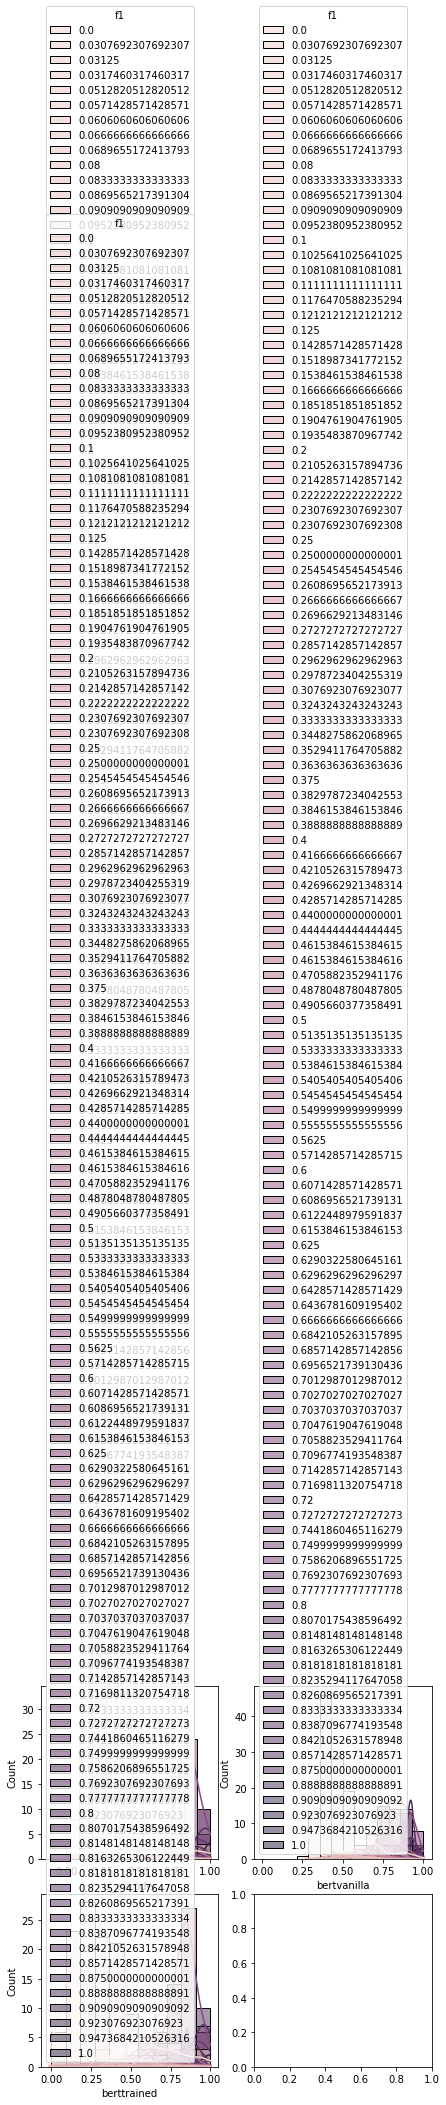

In [65]:
vis_hist_label(german_quad)

In [ ]:
german_quad

In [12]:
get_models_info()

,deepset/gbert-large-sts,cross-encoder/stsb-roberta-large,T-Systems-onsite/cross-en-de-roberta-sentence-transformer,bert-base-uncased,deepset/gelectra-base
_name_or_path,deepset/gbert-large,NaN,NaN,NaN,NaN
architectures,[BertForSequenceClassification],[RobertaForSequenceClassification],[XLMRobertaModel],[BertForMaskedLM],[ElectraForPreTraining]
attention_probs_dropout_prob,0.100,0.100,0.100,0.100,0.100
gradient_checkpointing,False,False,False,False,NaN
hidden_act,gelu,gelu,gelu,gelu,gelu
hidden_dropout_prob,0.100,0.100,0.100,0.100,NaN
hidden_size,"1,024.000","1,024.000",768.000,768.000,768.000
id2label,{'0': 'LABEL_0'},{'0': 'LABEL_0'},NaN,NaN,NaN
initializer_range,0.020,0.020,0.020,0.020,0.020
intermediate_size,"4,096.000","4,096.000","3,072.000","3,072.000","3,072.000"


## Score analysis

In [13]:
temp = squad.copy()

temp['dataset_type'] = 'SQuAD'

temp2 = german_quad.copy()
temp2['dataset_type'] = 'GermanQUAD'


temp3 = nq_open.copy()
temp3['dataset_type'] = 'NQ-open'

combo = pd.concat([temp, temp2[temp.columns], temp3[temp.columns]])


# new_df = pd.DataFrame()
# for i in range(3):
#     new_df = pd.concat([new_df , all_results[i][0].T], axis=1)
new_df = create_results_table([squad, german_quad, nq_open], return_paper_labels=False)


new_df.loc['meteor'] = list(new_df.loc['meteor'].values[:4]) +  \
    [np.nan, np.nan, np.nan, np.nan] + list(new_df.loc['meteor'].values[8:])
combo = combo[['answer1', 'answer2', 'label'] + list(new_df.index) + ['dataset_type']]

combo.columns = [
    'answer1', 'answer2',
    'Human', 'BLEU', 'ROUGE-L', 'METEOR', 'F1-score', 'Bi-Encoder', 
    'BERTScore vanilla', 'BERTScore trained', 'SAS', 'dataset_type'
]

/Users/faridamustafazade/opt/anaconda3/envs/projekt_nlu/lib/python3.8/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [14]:
df = pd.melt(combo, value_vars=['BLEU', 'ROUGE-L', 'METEOR', 'F1-score', 'Bi-Encoder', 
    'BERTScore vanilla', 'BERTScore trained', 'SAS'], id_vars='dataset_type')

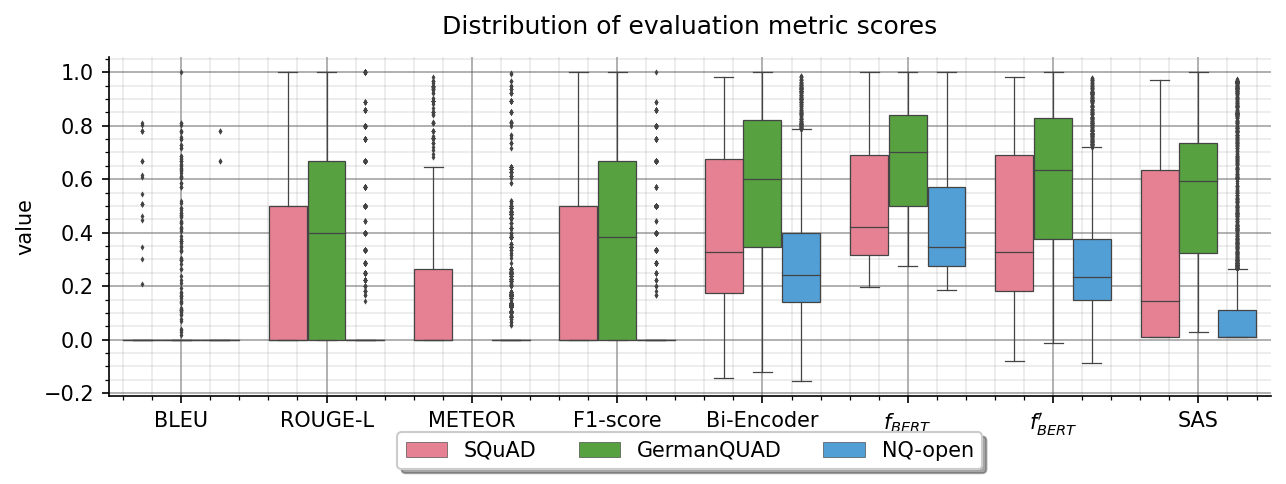

In [22]:
fig = pyplot.figure(figsize=(10, 3), dpi=150)
g = seaborn.boxplot(
    x='variable',
    y = 'value', 
    hue = 'dataset_type', 
    data=df.drop(df[(df['dataset_type'] == 'GermanQUAD') & (df.variable == 'METEOR')].index),
    palette='husl', 
    linewidth=0.6, 
    fliersize=.75)
pyplot.title('Distribution of evaluation metric scores', y=1.03)
xtick_labels = g.get_xticklabels()
g.set_xticklabels(xtick_labels[:5] + 
                  ['$f_{BERT}$', '$ f^{\prime}_{BERT}$'] + 
                  xtick_labels[7:])
# Put a legend below current axis
pyplot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.075),
          fancybox=True, shadow=True, ncol=5)

add_gridlines_remove_spines()

## Experiment with the layers

In [20]:
import pandas as pd

from bert_score import score
from haystack.modeling.evaluation.squad_evaluation import compute_f1
from haystack.modeling.utils import initialize_device_settings
from sentence_transformers import CrossEncoder, SentenceTransformer, util
from transformers import logging

BERTTRAINED = 'bert_score_prime'
BERT_VANILLA = 'bert_score'
BERT_UNCASED = 'bert-base-uncased'
SAS = 'sas'
F1_SCORE = 'f1'
model_type_trained = 'T-Systems-onsite/cross-en-de-roberta-sentence-transformer'

logging.set_verbosity_error()


In [142]:

# # BERTScore vanilla approach

# ## SQUAD 
# for layer in range(13):
#     _, _, bertscore = score(
#         list(squad.answer1.values),
#         list(squad.answer2.values),
#         model_type=BERT_UNCASED,
#         num_layers=layer)
#     squad[f'{layer}_{BERT_VANILLA}'] = bertscore.cpu().numpy()



# # BERTScore Trained


# ## SQUAD 
# for layer in range(13):
#     _, _, bertscore = score(
#         list(squad.answer1.values),
#         list(squad.answer2.values),
#         model_type=model_type_trained,
#         num_layers=layer)
#     squad[f'{layer}_{BERTTRAINED}'] = bertscore.cpu().numpy()



In [23]:
def plot_layer_extraction(data, title: str):
    labels = []
    figure = pyplot.figure(figsize=(7, 5), dpi=100)
    corr_df = defaultdict(list)
    for corr_func, marker in zip(
            [stats.pearsonr, stats.spearmanr, stats.kendalltau], ('s', '.', 'v')):
        for bert_score_type, label in zip(
                [BERT_VANILLA, BERTTRAINED], [r'$f_{BERT}$', r'$f^{\prime}_{BERT}$']):
            corrs = []

            for layer in range(13):
                corrs.append(
                    corr_func(data.loc[:, f'{layer}_{bert_score_type}'],
                              data.label)[0])
            figure = pyplot.plot(corrs, marker=marker)
            #         pyplot.ylim(0.18, 0.51)
        
            pyplot.plot([corr_func(data.sas, data.label)[0]] * 13, ls='dashed', marker=marker)
            pyplot.title(title, y=1.03)
            add_gridlines_remove_spines()
            labels.append(label + ', ' + corr_func.__name__.capitalize())
        labels.append('SAS' + ', ' + corr_func.__name__.capitalize())

    pyplot.legend(labels,
                  loc='upper center',
                  bbox_to_anchor=(0.5, -.075),
                  fancybox=True,
                  shadow=True,
                  ncol=3)

In [24]:
squad = pd.read_csv('data/table/squad_all_layer_results.csv')

In [189]:
# squad.to_csv('data/table/squad_all_layer_results.csv')

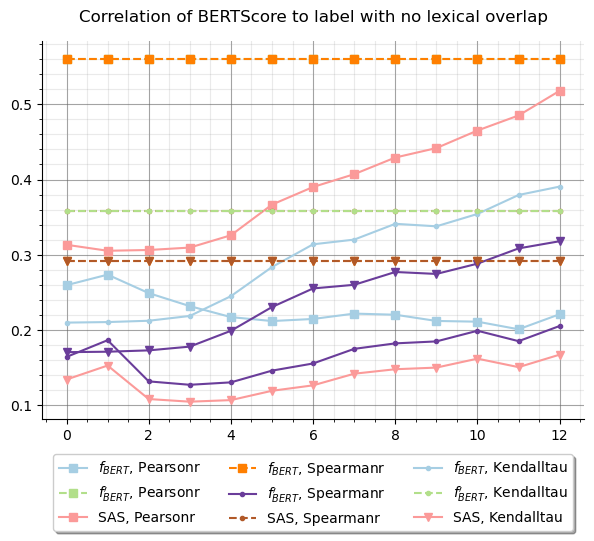

In [25]:
plot_layer_extraction(squad[squad.f1 == 0],
           'Correlation of BERTScore to label with no lexical overlap')

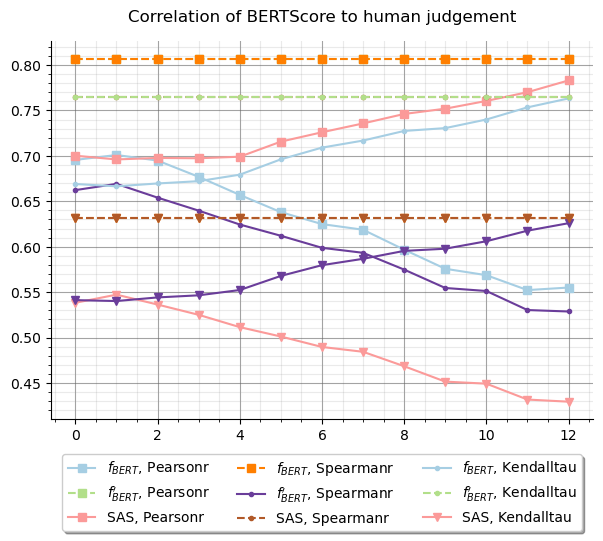

In [26]:
plot_layer_extraction(squad, 'Correlation of BERTScore to human judgement')

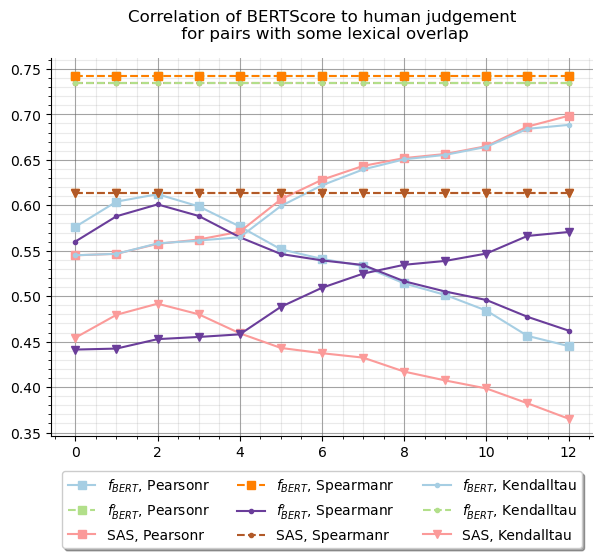

In [27]:
plot_layer_extraction(
    squad[squad.f1 != 0],
    'Correlation of BERTScore to human judgement\n for pairs with some lexical overlap'
)